# Задание

Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год.

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель

    Обучите модели на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей

    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import random
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv



In [2]:
import statsmodels.api as sm


def df_stationary_test(df_row: np.ndarray) -> bool:
    '''

    :param df_row: array_like, 1d

    :return: True if series is stationarity else False
    '''
    test = sm.tsa.adfuller(df_row)
    return test[0] <= test[4]['5%']


# Загрузка данных

In [3]:
df = yf.download('SPY', '2010-01-01')

[*********************100%***********************]  1 of 1 completed


# Обработка данных
#### Разбиение по неделям/месяцам

In [4]:
week_series = df.Close.resample('W').mean()

#### Отрисовка изначальных графиков цены (верхняя строка) и логарифма цены(нижняя строка), сгруппированных по неделям/месяцам

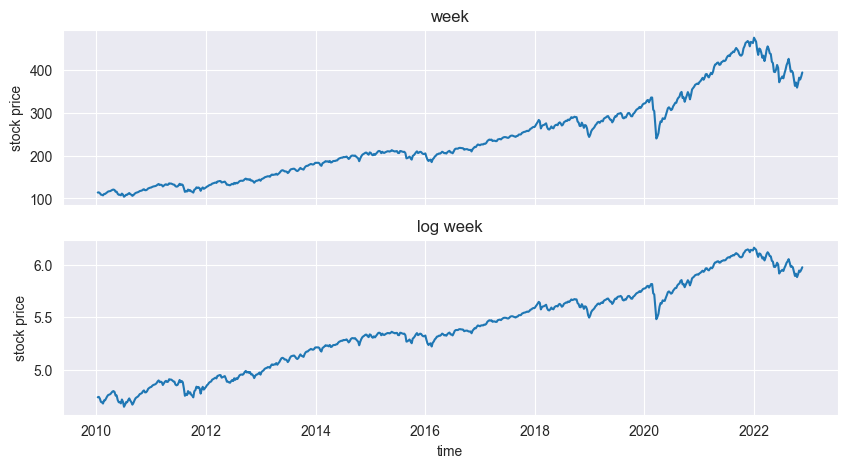

In [5]:
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].set_title("week")
axs[0].plot(week_series)

axs[1].set_title("log week")
axs[1].plot(np.log(week_series))


for ax in axs.flat:
    ax.set(xlabel='time', ylabel='stock price')

for ax in axs.flat:
    ax.label_outer()

In [6]:
data = week_series

#### Проверка рядов на старицонарность тестом DF

In [7]:
print('Ряд стационарен: {}'.format(df_stationary_test(data)))

Ряд стационарен: False


#### Удаление трендов

In [8]:
data_ln = np.log(data)

In [9]:
d_data = data_ln.diff(periods=1).dropna()

#### Проверка с помощью автокорелляции

Ряд без диффиренцирования стационарен: False


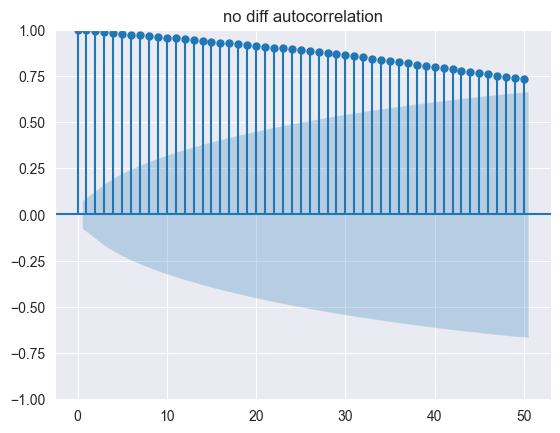

In [10]:
print('Ряд без диффиренцирования стационарен: {}'.format(df_stationary_test(data)))
x = plot_acf(data, lags=50, title='no diff autocorrelation')


Ряд с диффиренцированием стационарен: True


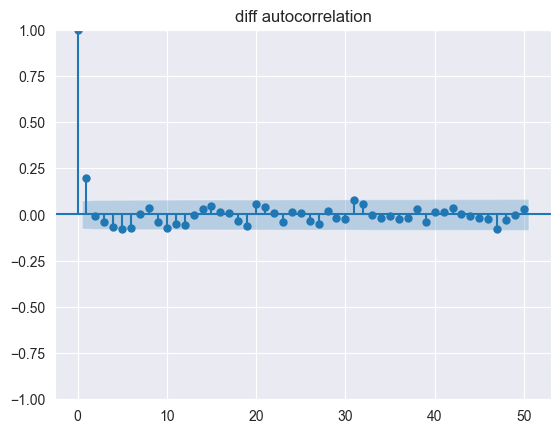

In [11]:
print('Ряд с диффиренцированием стационарен: {}'.format(df_stationary_test(d_data)))
x = plot_acf(d_data, lags=50, title='diff autocorrelation')

C:\Users\marse\AppData\Local\Temp\ipykernel_5096\1730095564.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


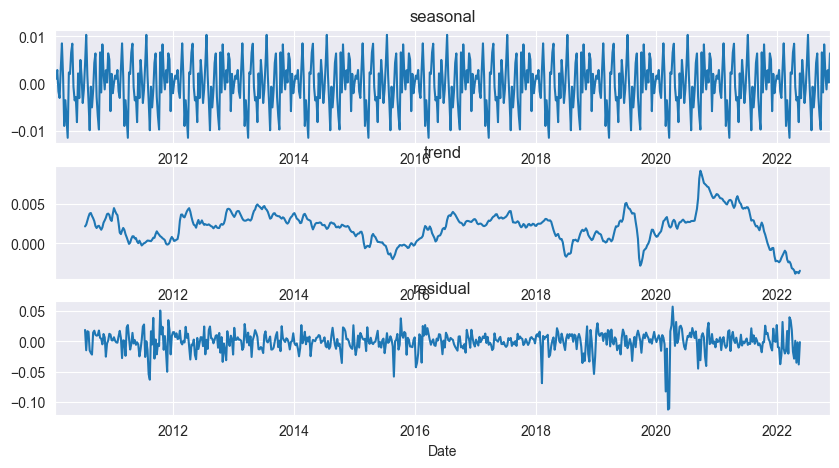

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
result = seasonal_decompose(d_data, model='additive')
result.seasonal.plot(ax=axs[0], title='seasonal')
result.trend.plot(ax=axs[1], title='trend')
result.resid.plot(ax=axs[2], title='residual')
fig.show()


# Обучение модели

Модель будем обучать на d_month_series, но перед этим проверим, что можем получить изначальный ряд по дифференцированному



In [13]:
def undiff(first_element, diffed):
    d  = diff_inv(diffed) + first_element
    return d

In [14]:
ud_ms = pd.Series(undiff(data_ln[0], d_data), index=data_ln.index)
ud_ms

Date
2010-01-10 00:00:00-05:00    4.735198
2010-01-17 00:00:00-05:00    4.738967
2010-01-24 00:00:00-05:00    4.722642
2010-01-31 00:00:00-05:00    4.691109
2010-02-07 00:00:00-05:00    4.686511
                               ...   
2022-10-23 00:00:00-04:00    5.911420
2022-10-30 00:00:00-04:00    5.947936
2022-11-06 00:00:00-04:00    5.936459
2022-11-13 00:00:00-05:00    5.955464
2022-11-20 00:00:00-05:00    5.979190
Freq: W-SUN, Length: 672, dtype: float64

In [15]:
print('Ряды совпадают: {}'.format(data_ln.equals(ud_ms)))

Ряды совпадают: True


#### Разобьем выборку на обучающую и тестовую, но с учётом, что это временной ряд

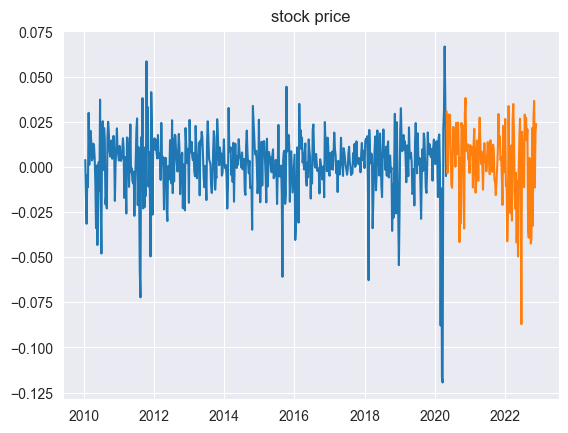

In [16]:
test_size = int(0.2 * len(d_data))
train_size = len(d_data) - test_size


d_train = d_data[:train_size]
d_test = d_data[train_size:]


plt.title('stock price')
plt.plot(d_train, label='Training set')
plt.plot(d_test, label='Testing set')
plt.show()

#### Обучим модель SARIMAX и получим prediction


In [17]:
model = auto_arima(d_train, start_p=0, start_q=0, test='adf', max_p=1, max_q=1, m=52,
                start_P=0, max_P=2, max_Q=2, d=0, D=1, seasonal=True, error_action ='ignore', supress_warnings=True)

# model = SARIMAX(d_train, order=(0, 0, 1), seasonal_order=(1, 1, 1, 52))


MemoryError: Unable to allocate 46.0 MiB for an array with shape (106, 106, 537) and data type float64

In [ ]:
# model.summary()

In [ ]:
prediction_sarima = model.predict(n_periods=test_size)


In [ ]:
# model_fit = model.fit()
# prediction_sarima = model_fit.predict(start=train_size, end=len(d_data)-1,dynamic=True)

#### Возвращаемся к исходным данным

In [ ]:
ud_ps = undiff(data_ln[train_size], prediction_sarima)
ud_ps = pd.Series(ud_ps, index=data_ln[train_size:].index)

In [ ]:
normal_prediction_sarima = np.exp(ud_ps)
plt.figure(figsize=(10, 5))
plt.plot(data, label = "Original")
plt.plot(normal_prediction_sarima, label = "Forecast")
plt.legend(fontsize=12)
plt.show()


In [ ]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data)/L)# кол-во cезонов
    seasonalities = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L*i: L*i+L])/float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i==0:
            smooth_val = data[0] # первое значения сглаживания
            trend_val = sum([(float(data[i+L] - data[i]) / L) for i in range(L)]) / L # первое значения тренда
            result.append(data[0]) # первая точка данных совпадает с исходной
            smooth.append(smooth_val) # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val) # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i%L]) # см mod L
            continue # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m*trend_val) + seasonalities[i%L])
        else: # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha*(data[i] - seasonalities[i%L]) + (1 - alpha)*(smooth_val + trend_val) # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val*(1 - beta) # обновляем bx
            seasonalities[i%L] = gamma * (data[i] - smooth_val) + (1 - gamma)*seasonalities[i%L] # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i%L]) # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i%L])
    return result[-m:]

In [ ]:
def check(x):
    alpha, beta, gamma = x
    preds = HolterWinter(d_train, 52, alpha, beta, gamma, len(d_test))
    return mean_squared_error(preds, d_test)

In [ ]:
optimizer = minimize(check, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha, beta, gamma = optimizer.x
print("alpha = ", alpha, "beta = ", beta, "gamma = ", gamma)

In [ ]:
prediction_hw = HolterWinter(d_train, 52, alpha, beta, gamma, len(d_test))
prediction_hw = pd.Series(prediction_hw, index=d_test.index)

In [ ]:
ud_pHW = undiff(data_ln[train_size], prediction_hw)
ud_pHW = pd.Series(ud_pHW, index=data_ln[train_size:].index)

normal_prediction_hw = np.exp(ud_pHW)


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(data, label = "Original", )
plt.plot(normal_prediction_sarima, label = "SARIMA")
plt.plot(normal_prediction_hw, label = "Holter-Winter")
plt.legend(fontsize=12)
plt.show()


In [ ]:
print("SARIMA MAE: {}".format(mean_squared_error(data[train_size:], normal_prediction_sarima)))
print("Holter-Winter MAE: {}".format(mean_squared_error(data[train_size:], normal_prediction_hw)))
print("SARIMA MAPE: {}".format(mean_absolute_percentage_error(data[train_size:], normal_prediction_sarima)))
print("Holter-Winter MAPE: {}".format(mean_absolute_percentage_error(data[train_size:], normal_prediction_hw)))